In [1]:
import numpy as np
import pandas as pd

from collections import defaultdict
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('ggplot')

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.metrics import  accuracy_score, balanced_accuracy_score, roc_auc_score, f1_score

# Group fairness' robustness on *adult income* dataset

In this notebook, we work with the *adult income* dataset. We start by loading and processing the data. Exploratory data analysis for the dataset can be found in *[eda_income](notebooks/eda_income.ipynb)*. We then create a baseline, evaluate the performance, fairness and feature importance of the model. Afterwards, we repeat but with a fairness constrained model, constrained on being fair for gender. We then similarly evaluate it, and compare the two models. Lastly, we scale the experiment to being fair for gender, age and nationality, to see how the method works in a realistic classification setting.

Start by loading in the data and doing some initial processing.

In [2]:
income = pd.read_csv('data/income.csv')
income['native-country'].apply(lambda x: x if x == 'United-States' else 'Other')
income['target'] = income.income.map({'<=50K': 0, '>50K': 1})

income['gender_group'] = income.gender.map({'Male': 0, 'Female': 1})

income.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income,target,gender_group
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K,0,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K,0,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K,1,0
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K,1,0
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K,0,1


Define which columns are going to be used for classification, whether they're going to get categorical or continuous preprocessing, and the groups used for debiasing.

In [3]:
nom_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'native-country']
num_features = ['educational-num']
target = 'target'
groups = 'gender_group'

For our preprocessing pipeline, we one-hot encode categorical features and standardscale all numerical features. Normally, when onehot encoding, we'd drop first for interpretability. However, since we're doing cross validation, we encode all values as features, and drop any features that are uknown in the validation set. Additionally, normally, we'd split the dataset into train and test. However, here, we're just interested in evaluating the robustness of the methods, and as such, we strictly use cross validation.  

In [4]:
preprocessing = ColumnTransformer(
    [('onehotencoder', OneHotEncoder(handle_unknown='ignore'), nom_features),
     ('standardscaler', StandardScaler(), num_features)
     ])

Throughout the project, we must evaluate the fairness of models. For this, we need to define which fairness criteria to fulfill. For this project, since we're using a group fairness constraint, we evaluate the fairness through *equalized odds*. It specifies the true positive ratio and false positive ratio for 2 groups must be equivalent.

$$
P(R=+|Y=y, A=a) = P(R=+|Y=y, A=b) \; y \in \{+, -\} \; \forall a,b \in A
$$

In [5]:
def equalized_odds(y_true, y_pred, groups):
    mask = groups == 0
    return y_pred[mask & (y_true == 1)].mean(), y_pred[~mask & (y_true == 1)].mean(), y_pred[mask & (y_true == 0)].mean(), y_pred[~mask & (y_true == 0)].mean()

### Baseline
For future reference, we start by making a baseline model without any fairness considerations to see what the performance and fairness of the model looks like.

The baseline is a binary logistic regression model. We implement it in pytorch as a single feed forward layer followed by sigmoid. We also implement a fit method for training the classifier. Since the original paper we base our research on uses l2-regularization, we also apply it with $\lambda = 0.01$.

In [6]:
class BinaryLogisticRegression(nn.Module):
    def __init__(self,
                 in_dim: int):
        super().__init__()
        
        self.linear = nn.Linear(in_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        return self.sigmoid(self.linear(x)).flatten()
    
    def fit(self, x, y, lr=0.01, weight_decay=0.01, batch_size=128, n_iter=10):
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        trainloader = DataLoader(TensorDataset(x, y), batch_size=batch_size, shuffle=True)
        
        for epoch in range(n_iter):
            for x, y in trainloader:
                y_pred = self(x)
                loss = criterion(y_pred, y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()


For easy tracking across models and k-folds, we implement a *KfoldTracker* to track performance, fairness and feature importance.

In [7]:
class KfoldTracker:
    def __init__(self):
        self.performance = defaultdict(list)
        self.fairness = defaultdict(list)
        self.feature_importance = defaultdict(list)
        self.group_tracker = defaultdict(KfoldTracker)

    def log_performance(self, y_true, y_pred):
        self.performance['Accuracy'].append(accuracy_score(y_true, y_pred))
        self.performance['Balanced accuracy'].append(balanced_accuracy_score(y_true, y_pred))
        self.performance['f1-score'].append(f1_score(y_true, y_pred))
        self.performance['ROC AUC'].append(roc_auc_score(y_true, y_pred))

    def log_fairness(self, y_true, y_pred, groups):
        tpr_g1, tpr_g2, fpr_g1, fpr_g2 = equalized_odds(y_true, y_pred, groups)
        self.fairness['TPR G1'].append(tpr_g1)
        self.fairness['TPR G2'].append(tpr_g2)
        self.fairness['FPR G1'].append(fpr_g1)
        self.fairness['FPR G2'].append(fpr_g2)

    def log_feature_importance(self, feature_importance, feature_names):
        for i, name in enumerate(feature_names):
            self.feature_importance[name].append(feature_importance[i])
        for key in self.feature_importance.keys():
            if key not in feature_names:
                self.feature_importance[key].append(np.nan)

    def log(self, y_true, y_pred, groups, feature_importance, feature_names):
        self.log_performance(y_true, y_pred)
        self.log_fairness(y_true, y_pred, groups)
        self.log_feature_importance(feature_importance, feature_names)

    def get_mean_performance(self):
        return {k: (np.mean(v), np.std(v)) for k, v in self.performance.items()}

    def get_mean_group_performance(self, group_name):
        return {k: (np.mean(v), np.std(v)) for k, v in self.group_performance[group_name].items()}
    
    def get_mean_fairness(self):
        return {k: (np.mean(v), np.std(v)) for k, v in self.fairness.items()}
    
    def get_mean_feature_importance(self):
        return {k: (np.mean(v), np.std(v)) for k, v in self.feature_importance.items()}

    def __str__(self):
        return str(pd.DataFrame(self.performance).T) + '\n\n' + str(pd.DataFrame(self.fairness).T) + '\n\n' + str(pd.DataFrame(self.feature_importance).T)
    
    def __getitem__(self, key):
        return self.group_tracker[key]

We train the baseline classifier with k-fold cross validation with $k=10$. This allows us to evaluate the models performance on different train-validation splits, and the uncertainty associated with it. 

In [8]:
tracker_base = KfoldTracker()

n_splits = 10
splits = KFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(splits.split(income)):
    train = income.iloc[train_idx]
    val = income.iloc[val_idx]
    
    x_train = preprocessing.fit_transform(train).toarray()
    y_train = train[target].values
    g_train = train[groups].values
    
    x_val = preprocessing.transform(val).toarray()
    y_val = val[target].values
    g_val = val[groups].values

    x_train, y_train, g_train, x_val, y_val, g_val = map(lambda x: torch.tensor(x, dtype=torch.float), (x_train, y_train, g_train, x_val, y_val, g_val))

    model = BinaryLogisticRegression(x_train.shape[1])
    model.fit(x_train, y_train)
    
    y_pred = model(x_val)
    y_pred = y_pred.detach().numpy().round()

    feature_importance = torch.exp(model.linear.weight).detach().numpy().squeeze()    
    feature_names = preprocessing.get_feature_names_out()
    tracker_base.log(y_val, y_pred, g_val, feature_importance, feature_names)

print(tracker_base)

                          0         1         2         3         4         5  \
Accuracy           0.829273  0.835824  0.834357  0.811220  0.826167  0.826577   
Balanced accuracy  0.705217  0.712714  0.713481  0.695168  0.711355  0.719378   
f1-score           0.567427  0.575212  0.577104  0.550244  0.573152  0.592593   
ROC AUC            0.705217  0.712714  0.713481  0.695168  0.711355  0.719378   

                          6         7         8         9  
Accuracy           0.822482  0.827805  0.828419  0.822072  
Balanced accuracy  0.690430  0.705648  0.721131  0.702536  
f1-score           0.541512  0.558530  0.590820  0.566151  
ROC AUC            0.690430  0.705648  0.721131  0.702536  

               0         1         2         3         4         5         6  \
TPR G1  0.491388  0.507217  0.524008  0.490839  0.515996  0.532430  0.460317   
TPR G2  0.335135  0.344595  0.290698  0.308989  0.376344  0.354839  0.289157   
FPR G1  0.087168  0.093246  0.090013  0.104859  0.106

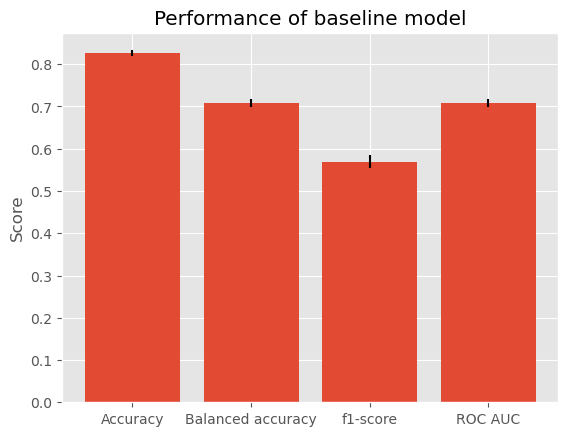

In [9]:
perf_base = tracker_base.get_mean_performance()
fig, ax = plt.subplots()
ax.bar(perf_base.keys(), [v[0] for v in perf_base.values()], yerr=[v[1] for v in perf_base.values()])
ax.set_title('Performance of baseline model')
ax.set_ylabel('Score')

FIG_PATH = 'reports/figs/'
def savefig(fname, dpi=None):
    dpi = 150 if dpi == None else dpi
    plt.savefig(os.path.join(FIG_PATH, fname), bbox_inches='tight', dpi=dpi)
    
savefig('baseline_performance.svg')

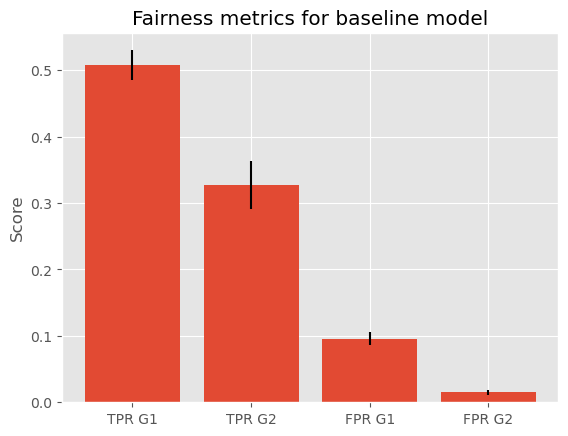

In [10]:
fairness_base = tracker_base.get_mean_fairness()
fig, ax = plt.subplots()
ax.bar(fairness_base.keys(), [v[0] for v in fairness_base.values()], yerr=[v[1] for v in fairness_base.values()])
ax.set_title('Fairness metrics for baseline model')
ax.set_ylabel('Score')
savefig('baseline_fairness.svg')

We evaluate feature importance across all k-folds, and use the multiple folds for estimating the uncertainty of the model. Since we're using a logistic regression model, we can calculate the odds ratio between $x$ and $x'$, where $x$ and $x'$ are identical except for one feature, as:

$$
\frac{odds(x')}{odds(x)} = e^{\beta_j}
$$


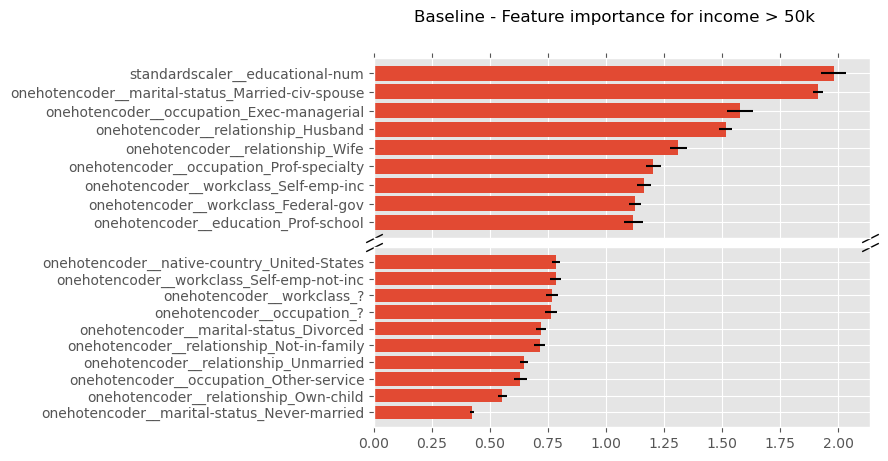

In [11]:
def plot_feature_importance(feature_importance):

    means = np.array([value[0] for value in feature_importance.values()])
    stds = np.array([value[1] for value in feature_importance.values()])
    keys = np.array(list(feature_importance.keys()))

    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.subplots_adjust(hspace=0.05)
    idx = np.argsort(means)
    idx = np.concatenate((idx[:10], idx[-10:]))

    ax1.barh(keys[idx[10:]], means[idx[10:]], xerr=stds[idx[10:]])
    ax2.barh(keys[idx[:10]], means[idx[:10]], xerr=stds[idx[:10]])

    ax1.xaxis.tick_top()

    d = .5
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
    ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

    return fig, (ax1, ax2)

feature_importance_base = tracker_base.get_mean_feature_importance()
fig, (ax1, ax2) = plot_feature_importance(feature_importance_base)
fig.suptitle('Baseline - Feature importance for income > 50k')
savefig('baseline_feature_importance.svg')

### Fair model - enforcing fairness through constrained optimization

To debias models, we implement the group fairness constraint from:

Richard Berk, Hoda Heidari, Shahin Jabbari, Matthew Joseph, Michael Kearns, Jamie Morgenstern, Seth
Neel, and Aaron Roth. A convex framework for fair regression. arXiv preprint arXiv:1706.02409, 2017.

$$
f_2(\mathbf{w}, S)=\left(\frac{1}{n_1 n_2} \sum_{\substack{\left(\mathbf{x}_i, y_i\right) \in S_1 \\\left(\mathbf{x}_j, y_j\right) \in S_2}} d\left(y_i, y_j\right)\left(\mathbf{w} \cdot \mathbf{x}_i-\mathbf{w} \cdot \mathbf{x}_j\right)\right)^2
$$

This cost function does not work in our setting. We initially tested with it, but we experienced that it didn't work for us. Instead, we let *g* be our decision function $g(x) = \frac{1}{1 + e^{-(wx)}}$, and implement the loss as:

$$
f_2(\mathbf{w}, S)=\frac{1}{n_1 n_2} \left(\sum_{\substack{\left(\mathbf{x}_i, y_i\right) \in S_1 \\\left(\mathbf{x}_j, y_j\right) \in S_2}} d\left(y_i, y_j\right)\left(g(\mathbf{x}_i) - g(\mathbf{x}_j) \right)\right)^2
$$

We implement this as an optimization constrain for our fair model, such that we use it as a regulerization term, with parameter $\gamma$ used as regulerization strength. As such, the loss function we're optimizing becomes.

$$
\mathcal{L} = - \frac{1}{N} \left[ \sum_{i=1}^N y_i \; log \, g_\beta(\mathbf{x}_i) + (1 - y_i) \; log \, (1-g_\beta(\mathbf{x}_i)) \right] 
+ 
\gamma \left( \frac{1}{n_1 n_2} \left(\sum_{\substack{\left(\mathbf{x}_i, y_i\right) \in S_1 \\\left(\mathbf{x}_j, y_j\right) \in S_2}} d\left(y_i, y_j\right)\left( g_\beta(\mathbf{x}_i) - g_\beta(\mathbf{x}_j) \right)\right)^2 \right) + \lambda ||\beta||_2
$$

In [12]:
class GroupFairnessConstraint(nn.Module):
    def __init__(self):
        super(GroupFairnessConstraint, self).__init__()
        
    def forward(self, y_pred, y_true, groups):
        mask = groups == 0
        S_pred_1, S_true_1 = y_pred[mask],  y_true[mask]
        S_pred_2, S_true_2 = y_pred[~mask], y_true[~mask]
        
        n_1 = S_pred_1.shape[0]
        n_2 = S_pred_2.shape[0]

        idx1 = torch.arange(n_1)
        idx2 = torch.arange(n_2)

        idx1 = idx1.view(-1, 1)
        idx2 = idx2.view(1, -1)

        idx1 = idx1.repeat(1, idx2.size(1))
        idx2 = idx2.repeat(idx1.size(0), 1)

        result = torch.stack((idx1, idx2), dim=2).view(-1, 2)
        idx1 = result[:, 0]
        idx2 = result[:, 1]
        
        vector = self.d(S_true_1[idx1], S_true_2[idx2]) * (S_pred_1[idx1] - S_pred_2[idx2])
        cost = vector.sum()
        cost = cost ** 2
        cost = cost / (n_1*n_2)

        return cost
        
    def d(self, y_i, y_j):
        return (y_i == y_j).int()
    
class FairBinaryLogisticRegression(BinaryLogisticRegression):
    def __init__(self, in_dim: int, gamma: float = 1e-4):
        super().__init__(in_dim)
        self.gamma = gamma
    
    def fit(self, x, y, g, lr=0.01, weight_decay=0.01, batch_size=128, n_iter=10, verbose=False):
        criterion = nn.BCELoss()
        fair_criterion = GroupFairnessConstraint()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        trainloader = DataLoader(TensorDataset(x, y, g), batch_size=batch_size, shuffle=True)
        
        for epoch in range(n_iter):
            for x, y, g in trainloader:
                y_pred = self(x)
                loss_bce = criterion(y_pred, y)
                loss_fair = self.gamma * fair_criterion(y_pred, y, g)
                loss = loss_bce + loss_fair

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if verbose:
                    print(f'Epoch: {epoch}, Loss BCE: {round(loss_bce.item(), 4)}, Loss Fair: {round(loss_fair.item(), 4)}')


We implement a gridsearch for finding the optimal $\gamma$ for the optimal accuracy-fairness tradeoff.

In [13]:
gammaspace = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
trackers = []

for gamma in gammaspace:
    tracker_fair = KfoldTracker()

    n_splits = 5
    splits = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    for fold, (train_idx, val_idx) in enumerate(splits.split(income)):
        train = income.iloc[train_idx]
        val = income.iloc[val_idx]
        
        x_train = preprocessing.fit_transform(train).toarray()
        y_train = train[target].values
        g_train = train[groups].values
        
        x_val = preprocessing.transform(val).toarray()
        y_val = val[target].values
        g_val = val[groups].values

        x_train, y_train, g_train, x_val, y_val, g_val = map(lambda x: torch.tensor(x, dtype=torch.float), (x_train, y_train, g_train, x_val, y_val, g_val))

        model = FairBinaryLogisticRegression(x_train.shape[1], gamma=gamma)
        model.fit(x_train, y_train, g_train)
        
        y_pred = model(x_val)
        y_pred = y_pred.detach().numpy().round()

        feature_importance = torch.exp(model.linear.weight).detach().numpy().squeeze()    
        feature_names = preprocessing.get_feature_names_out()
        tracker_fair.log(y_val, y_pred, g_val, feature_importance, feature_names)

        mask = g_val == 0
        tracker_fair['male'].log_performance(y_val[mask], y_pred[mask])
        tracker_fair['female'].log_performance(y_val[~mask], y_pred[~mask])

    trackers.append(tracker_fair)


We plot the gamma search in pareto curves to find the optimal gamma value.

Text(0, 0.5, 'TPR')

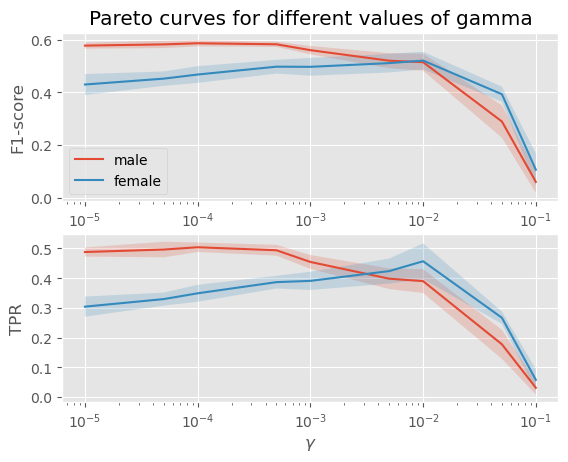

In [14]:
male_perf = np.array([t['male'].get_mean_performance()['f1-score'][0] for t in trackers])
female_perf = np.array([t['female'].get_mean_performance()['f1-score'][0] for t in trackers])

male_unc = np.array([t['male'].get_mean_performance()['f1-score'][1] for t in trackers])
female_unc = np.array([t['female'].get_mean_performance()['f1-score'][1] for t in trackers])

tpr_g1 = np.array([t.get_mean_fairness()['TPR G1'][0] for t in trackers])
tpr_g2 = np.array([t.get_mean_fairness()['TPR G2'][0] for t in trackers])
tpr_g1_unc = np.array([t.get_mean_fairness()['TPR G1'][1] for t in trackers])
tpr_g2_unc = np.array([t.get_mean_fairness()['TPR G2'][1] for t in trackers])

fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(gammaspace, male_perf, label='male')
ax1.plot(gammaspace, female_perf, label='female')

ax1.fill_between(gammaspace, male_perf + male_unc, male_perf - male_unc, alpha=0.2)
ax1.fill_between(gammaspace, female_perf + female_unc, female_perf - female_unc, alpha=0.2)

ax1.set_xscale('log')

ax1.set_ylabel('F1-score')

ax1.legend()

ax1.set_title('Pareto curves for different values of gamma')

ax2.plot(gammaspace, tpr_g1, label='TPR G1')
ax2.plot(gammaspace, tpr_g2, label='TPR G2')

ax2.fill_between(gammaspace, tpr_g1 + tpr_g1_unc, tpr_g1 - tpr_g1_unc, alpha=0.2)
ax2.fill_between(gammaspace, tpr_g2 + tpr_g2_unc, tpr_g2 - tpr_g2_unc, alpha=0.2)

ax2.set_xscale('log')
ax2.set_xlabel('$\gamma$')
ax2.set_ylabel('TPR')

By investigating the pareto curves empirically, we see that $\gamma = 0.005$ achieves the best tradeoff between performance and fairness. We train a new model with this gamma value. 

In [15]:
tracker_fair = KfoldTracker()

gamma = 5e-3

n_splits = 10
splits = KFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(splits.split(income)):
    train = income.iloc[train_idx]
    val = income.iloc[val_idx]
    
    x_train = preprocessing.fit_transform(train).toarray()
    y_train = train[target].values
    g_train = train[groups].values
    
    x_val = preprocessing.transform(val).toarray()
    y_val = val[target].values
    g_val = val[groups].values

    x_train, y_train, g_train, x_val, y_val, g_val = map(lambda x: torch.tensor(x, dtype=torch.float), (x_train, y_train, g_train, x_val, y_val, g_val))

    model = FairBinaryLogisticRegression(x_train.shape[1], gamma=gamma)
    model.fit(x_train, y_train, g_train)
    
    y_pred = model(x_val)
    y_pred = y_pred.detach().numpy().round()

    feature_importance = torch.exp(model.linear.weight).detach().numpy().squeeze()    
    feature_names = preprocessing.get_feature_names_out()
    tracker_fair.log(y_val, y_pred, g_val, feature_importance, feature_names)
    
print(tracker_fair)

                          0         1         2         3         4         5  \
Accuracy           0.821699  0.832753  0.833538  0.807944  0.822686  0.822891   
Balanced accuracy  0.680966  0.696886  0.688205  0.651700  0.676505  0.690369   
f1-score           0.524823  0.549862  0.537279  0.468856  0.515660  0.545455   
ROC AUC            0.680966  0.696886  0.688205  0.651700  0.676505  0.690369   

                          6         7         8         9  
Accuracy           0.821253  0.828829  0.819615  0.821253  
Balanced accuracy  0.685837  0.686669  0.681410  0.688161  
f1-score           0.533405  0.529809  0.525579  0.541732  
ROC AUC            0.685837  0.686669  0.681410  0.688161  

               0         1         2         3         4         5         6  \
TPR G1  0.398176  0.448454  0.418580  0.337512  0.386997  0.411423  0.430556   
TPR G2  0.475676  0.432432  0.412791  0.359551  0.462366  0.505376  0.391566   
FPR G1  0.057522  0.067538  0.051436  0.043052  0.057

With this model, we evaluate the performance, fairness and feature importance. 

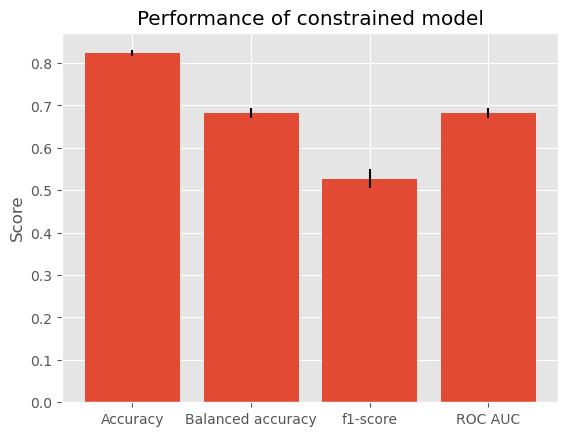

In [16]:
perf_fair = tracker_fair.get_mean_performance()
fig, ax = plt.subplots()
ax.bar(perf_fair.keys(), [v[0] for v in perf_fair.values()], yerr=[v[1] for v in perf_fair.values()])
ax.set_title('Performance of constrained model')
ax.set_ylabel('Score')
savefig('constrained_performance.svg')

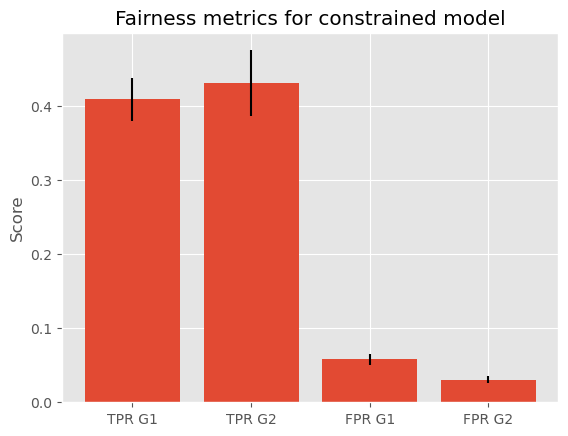

In [17]:
fairness_fair = tracker_fair.get_mean_fairness()
fig, ax = plt.subplots()
ax.bar(fairness_fair.keys(), [v[0] for v in fairness_fair.values()], yerr=[v[1] for v in fairness_fair.values()])
ax.set_title('Fairness metrics for constrained model')
ax.set_ylabel('Score')
savefig('constrained_fairness.svg')

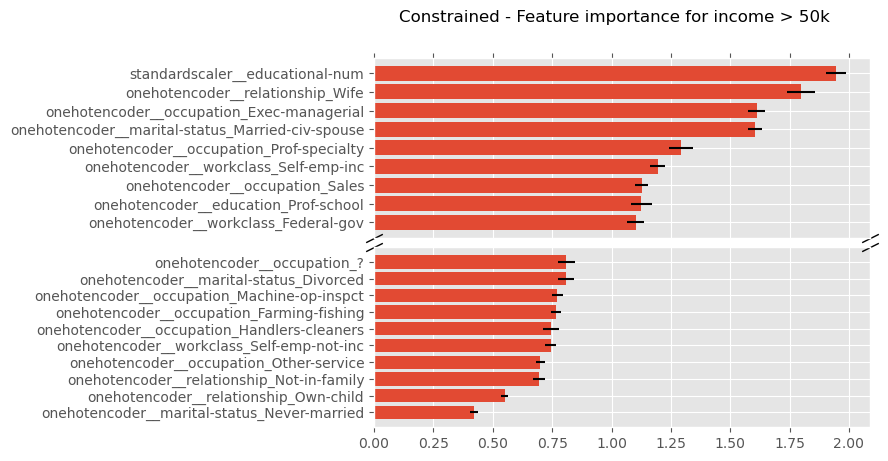

In [18]:
feature_importance_fair = tracker_fair.get_mean_feature_importance()
fig, (ax1, ax2) = plot_feature_importance(feature_importance_fair)
fig.suptitle('Constrained - Feature importance for income > 50k')
savefig('constrained_feature_importance.svg')

### Comparison of baseline and fair model

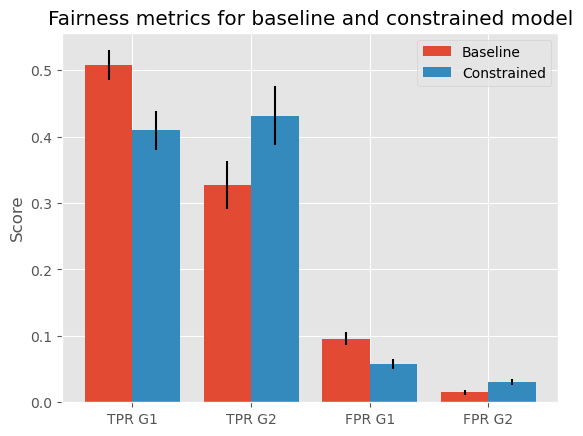

In [19]:
fig, ax = plt.subplots()
ax.bar(np.arange(len(fairness_base.keys())) - .2, [v[0] for v in fairness_base.values()], yerr=[v[1] for v in fairness_base.values()], width=.4, label='Baseline')
ax.bar(np.arange(len(fairness_fair.keys())) + .2, [v[0] for v in fairness_fair.values()], yerr=[v[1] for v in fairness_fair.values()], width=.4, label='Constrained')
ax.set_title('Fairness metrics for baseline and constrained model')
ax.set_ylabel('Score')

ax.set_xticks(np.arange(len(fairness_base.keys())))
ax.set_xticklabels(fairness_base.keys())

ax.legend()
savefig('fairness_comparison.svg')

We compare feature importance of the baseline and fair model across k folds, visualizing the mean feature importance and the uncertainty. The ideal outcume is that the fair model bases its decisions on features that aren't a proxy for gender. We visualize all features in one plot and the features highly correlated with gender in another.

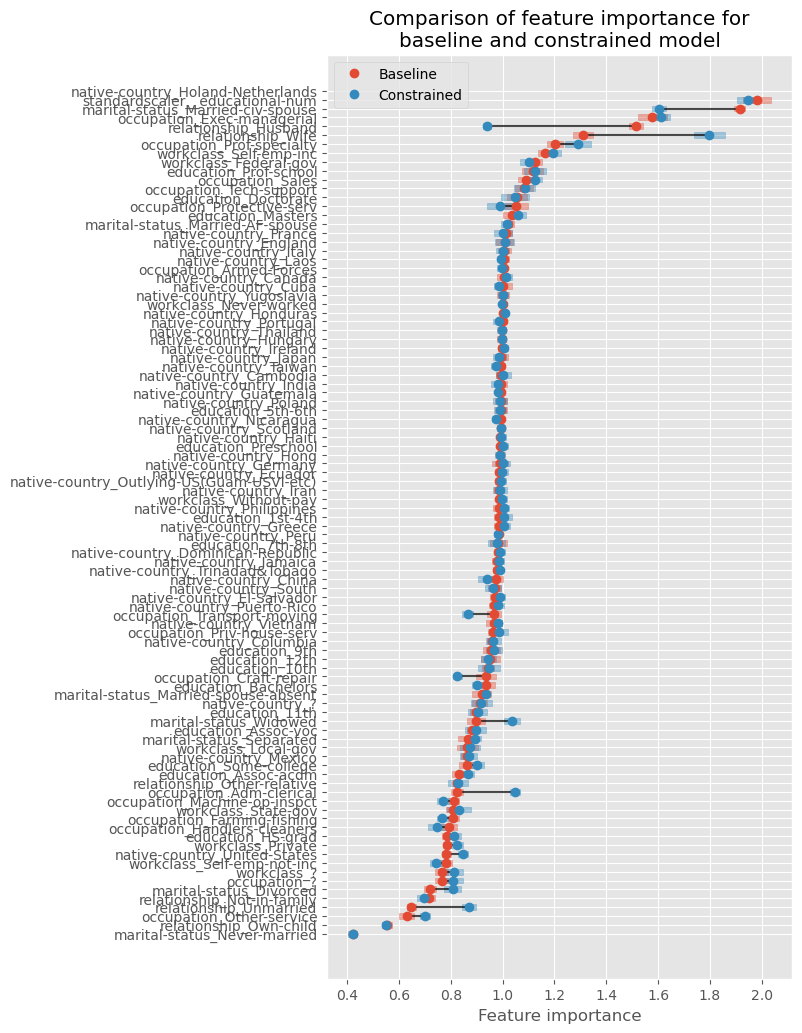

In [20]:
categories = np.array(list(feature_importance_base.keys()))
values_base = np.array([v[0] for v in feature_importance_base.values()])
values_fair = np.array([v[0] for v in feature_importance_fair.values()])
uncertainty_base = np.array([v[1] for v in feature_importance_base.values()])
uncertainty_fair = np.array([v[1] for v in feature_importance_fair.values()])

categories = np.array([cat.split('__')[1] if 'onehotencoder' in cat else cat for cat in categories])

idx = np.argsort(values_base)
categories, values_base, values_fair, uncertainty_base, uncertainty_fair = map(lambda x: x[idx], (categories, values_base, values_fair, uncertainty_base, uncertainty_fair))

fig, ax = plt.subplots(figsize=(6, 12))

red = mpl.rcParams['axes.prop_cycle'].by_key()['color'][0]
blue = mpl.rcParams['axes.prop_cycle'].by_key()['color'][1]

for i in range(len(categories)):
    ax.plot([values_base[i], values_fair[i]], [i, i], color='black', alpha=.7)

for i in range(len(categories)):
    ax.plot(values_base[i], i, 'o', color=red, label='Baseline' if i == 0 else None)
    ax.plot(values_fair[i], i, 'o', color=blue, label='Constrained' if i == 0 else None)
    ax.fill_betweenx([i-0.33, i+0.33], values_base[i]-uncertainty_base[i], values_base[i]+uncertainty_base[i], color=red, alpha=0.4)
    ax.fill_betweenx([i-0.33, i+0.33], values_fair[i]-uncertainty_fair[i], values_fair[i]+uncertainty_fair[i], color=blue, alpha=0.4)

ax.set_yticks(range(len(categories)))
ax.set_yticklabels(categories)

ax.set_xlabel('Feature importance')

ax.set_title('Comparison of feature importance for\nbaseline and constrained model')

ax.legend()

savefig('feature_importance_comparison.svg')

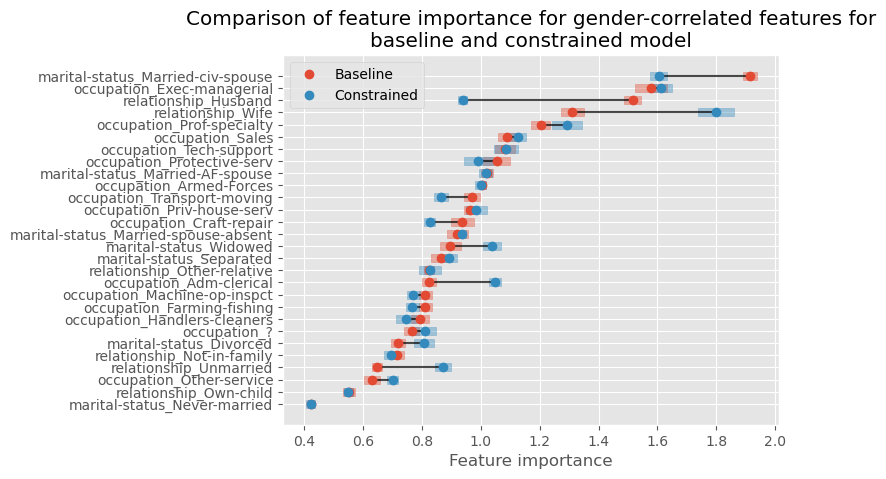

In [21]:
categories = np.array(list(feature_importance_base.keys()))
values_base = np.array([v[0] for v in feature_importance_base.values()])
values_fair = np.array([v[0] for v in feature_importance_fair.values()])
uncertainty_base = np.array([v[1] for v in feature_importance_base.values()])
uncertainty_fair = np.array([v[1] for v in feature_importance_fair.values()])

categories = np.array([cat.split('__')[1] if 'onehotencoder' in cat else cat for cat in categories])

mask = [True if 'marital' in cat or 'occupation' in cat or 'relationship' in cat else False for cat in categories]
categories, values_base, values_fair, uncertainty_base, uncertainty_fair = map(lambda x: x[mask], (categories, values_base, values_fair, uncertainty_base, uncertainty_fair))

idx = np.argsort(values_base)
categories, values_base, values_fair, uncertainty_base, uncertainty_fair = map(lambda x: x[idx], (categories, values_base, values_fair, uncertainty_base, uncertainty_fair))

fig, ax = plt.subplots()

red = mpl.rcParams['axes.prop_cycle'].by_key()['color'][0]
blue = mpl.rcParams['axes.prop_cycle'].by_key()['color'][1]

for i in range(len(categories)):
    ax.plot([values_base[i], values_fair[i]], [i, i], color='black', alpha=.7)

for i in range(len(categories)):
    ax.plot(values_base[i], i, 'o', color=red, label='Baseline' if i == 0 else None)
    ax.plot(values_fair[i], i, 'o', color=blue, label='Constrained' if i == 0 else None)
    ax.fill_betweenx([i-0.33, i+0.33], values_base[i]-uncertainty_base[i], values_base[i]+uncertainty_base[i], color=red, alpha=0.4)
    ax.fill_betweenx([i-0.33, i+0.33], values_fair[i]-uncertainty_fair[i], values_fair[i]+uncertainty_fair[i], color=blue, alpha=0.4)

ax.set_yticks(range(len(categories)))
ax.set_yticklabels(categories)

ax.set_xlabel('Feature importance')

ax.set_title('Comparison of feature importance for gender-correlated features for\nbaseline and constrained model')

ax.legend()

savefig('correlated_feature_importance_comparison.svg')

### Application of method on 3 protected groups

In [35]:
income['race_group'] = income['race'].apply(lambda x: 1 if x == 'White' else 0)
income['age_group'] = income['age'].apply(lambda x: 1 if x < 35 else 0)

groups = ['gender_group', 'race_group', 'age_group']

In [50]:
class VeryFairBinaryLogisticRegression(BinaryLogisticRegression):
    def __init__(self, in_dim: int, gamma: float = 1e-4):
        super().__init__(in_dim)
        self.gamma = gamma
    
    def fit(self, x, y, gs, lr=0.01, weight_decay=0.01, batch_size=128, n_iter=10, verbose=False):
        criterion = nn.BCELoss()
        fair_criterion = GroupFairnessConstraint()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        trainloader = DataLoader(TensorDataset(x, y, gs), batch_size=batch_size, shuffle=True)
        
        for epoch in range(n_iter):
            for x, y, g in trainloader:
                y_pred = self(x)
                loss_bce = criterion(y_pred, y)
                loss_fair = sum([self.gamma * fair_criterion(y_pred, y, g[:, idx]) for idx in range(g.shape[1])])
                loss = loss_bce + loss_fair

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if verbose:
                    print(f'Epoch: {epoch}, Loss BCE: {round(loss_bce.item(), 4)}, Loss Fair: {round(loss_fair.item(), 4)}')


In [53]:
tracker_3 = KfoldTracker()

gamma = 5e-3

n_splits = 10
splits = KFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(splits.split(income)):
    train = income.iloc[train_idx]
    val = income.iloc[val_idx]
    
    x_train = preprocessing.fit_transform(train).toarray()
    y_train = train[target].values
    g_train = train[groups].values
    
    x_val = preprocessing.transform(val).toarray()
    y_val = val[target].values
    g_val = val[groups].values

    x_train, y_train, g_train, x_val, y_val, g_val = map(lambda x: torch.tensor(x, dtype=torch.float), (x_train, y_train, g_train, x_val, y_val, g_val))

    model = VeryFairBinaryLogisticRegression(x_train.shape[1], gamma=gamma)
    model.fit(x_train, y_train, g_train)
    
    y_pred = model(x_val)
    y_pred = y_pred.detach().numpy().round()

    feature_importance = torch.exp(model.linear.weight).detach().numpy().squeeze()    
    feature_names = preprocessing.get_feature_names_out()
    tracker_3.log(y_val, y_pred, g_val[:,0], feature_importance, feature_names)
    
print(tracker_3)

                          0         1         2         3         4         5  \
Accuracy           0.815353  0.816172  0.829238  0.796274  0.811835  0.806102   
Balanced accuracy  0.646135  0.621977  0.673036  0.615858  0.633241  0.638120   
f1-score           0.454655  0.396505  0.508834  0.385423  0.425266  0.437982   
ROC AUC            0.646135  0.621977  0.673036  0.615858  0.633241  0.638120   

                          6         7         8         9  
Accuracy           0.813473  0.818591  0.805487  0.803849  
Balanced accuracy  0.652185  0.632732  0.625424  0.628821  
f1-score           0.468184  0.422425  0.407731  0.415140  
ROC AUC            0.652185  0.632732  0.625424  0.628821  

               0         1         2         3         4         5         6  \
TPR G1  0.305978  0.250515  0.385177  0.243973  0.272446  0.275895  0.338294   
TPR G2  0.400000  0.351351  0.366279  0.331461  0.408602  0.451613  0.361446   
FPR G1  0.035398  0.025708  0.045435  0.028133  0.033

Text(0, 0.5, 'Score')

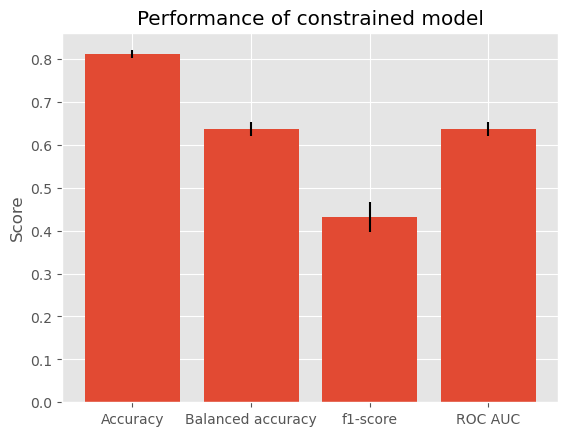

In [55]:
perf_3 = tracker_3.get_mean_performance()
fig, ax = plt.subplots()
ax.bar(perf_3.keys(), [v[0] for v in perf_3.values()], yerr=[v[1] for v in perf_3.values()])
ax.set_title('Performance of constrained model')
ax.set_ylabel('Score')
# savefig('constrained_performance.svg')

Text(0.5, 0.98, 'Constrained - Feature importance for income > 50k')

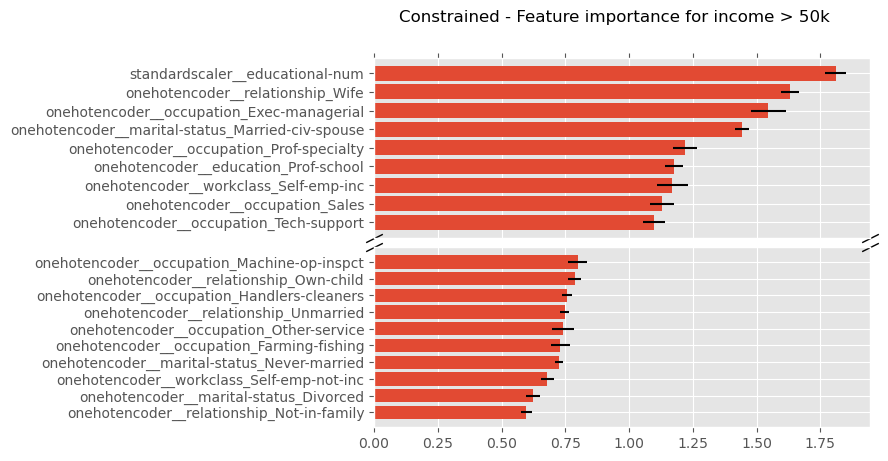

In [54]:
feature_importance_3 = tracker_3.get_mean_feature_importance()
fig, (ax1, ax2) = plot_feature_importance(feature_importance_3)
fig.suptitle('Constrained - Feature importance for income > 50k')
# savefig('constrained_feature_importance.svg')

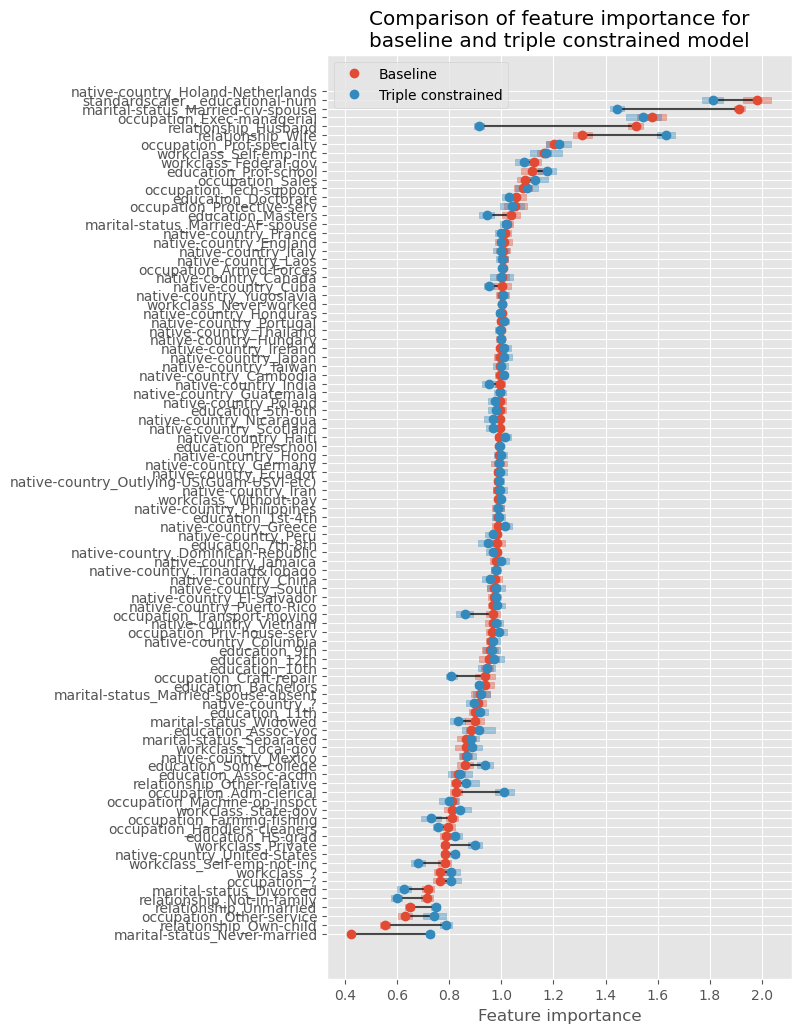

In [62]:
categories = np.array(list(feature_importance_base.keys()))
values_base = np.array([v[0] for v in feature_importance_base.values()])
values_3 = np.array([v[0] for v in feature_importance_3.values()])
uncertainty_base = np.array([v[1] for v in feature_importance_base.values()])
uncertainty_3 = np.array([v[1] for v in feature_importance_3.values()])

categories = np.array([cat.split('__')[1] if 'onehotencoder' in cat else cat for cat in categories])

idx = np.argsort(values_base)
categories, values_base, values_3, uncertainty_base, uncertainty_3 = map(lambda x: x[idx], (categories, values_base, values_3, uncertainty_base, uncertainty_3))

fig, ax = plt.subplots(figsize=(6, 12))

red = mpl.rcParams['axes.prop_cycle'].by_key()['color'][0]
blue = mpl.rcParams['axes.prop_cycle'].by_key()['color'][1]

for i in range(len(categories)):
    ax.plot([values_base[i], values_3[i]], [i, i], color='black', alpha=.7)

for i in range(len(categories)):
    ax.plot(values_base[i], i, 'o', color=red, label='Baseline' if i == 0 else None)
    ax.plot(values_3[i], i, 'o', color=blue, label='Triple constrained' if i == 0 else None)
    ax.fill_betweenx([i-0.33, i+0.33], values_base[i]-uncertainty_base[i], values_base[i]+uncertainty_base[i], color=red, alpha=0.4)
    ax.fill_betweenx([i-0.33, i+0.33], values_3[i]-uncertainty_3[i], values_3[i]+uncertainty_3[i], color=blue, alpha=0.4)

ax.set_yticks(range(len(categories)))
ax.set_yticklabels(categories)

ax.set_xlabel('Feature importance')

ax.set_title('Comparison of feature importance for\nbaseline and triple constrained model')

ax.legend()

savefig('correlated_feature_importance_comparison_triple.svg')

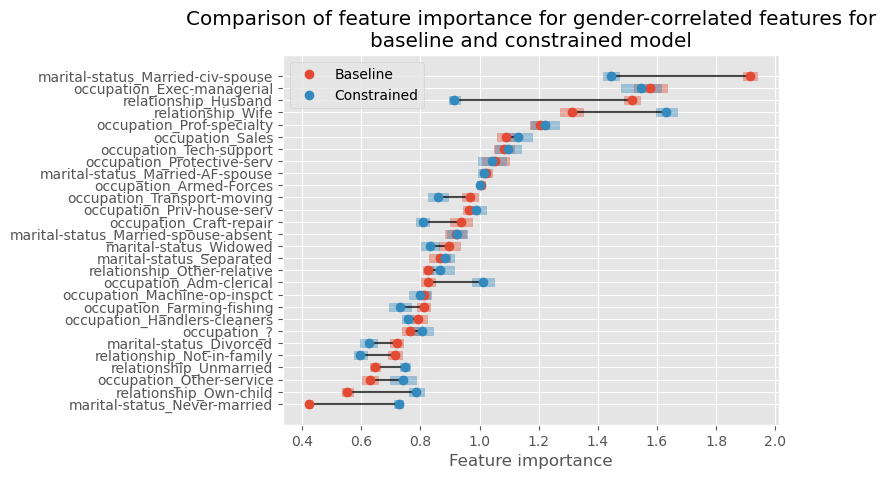

In [ ]:
categories = np.array(list(feature_importance_base.keys()))
values_base = np.array([v[0] for v in feature_importance_base.values()])
values_3 = np.array([v[0] for v in feature_importance_3.values()])
uncertainty_base = np.array([v[1] for v in feature_importance_base.values()])
uncertainty_3 = np.array([v[1] for v in feature_importance_3.values()])

categories = np.array([cat.split('__')[1] if 'onehotencoder' in cat else cat for cat in categories])

mask = [True if 'marital' in cat or 'occupation' in cat or 'relationship' in cat else False for cat in categories]
categories, values_base, values_3, uncertainty_base, uncertainty_3 = map(lambda x: x[mask], (categories, values_base, values_3, uncertainty_base, uncertainty_3))

idx = np.argsort(values_base)
categories, values_base, values_3, uncertainty_base, uncertainty_3 = map(lambda x: x[idx], (categories, values_base, values_3, uncertainty_base, uncertainty_3))

fig, ax = plt.subplots()

red = mpl.rcParams['axes.prop_cycle'].by_key()['color'][0]
blue = mpl.rcParams['axes.prop_cycle'].by_key()['color'][1]

for i in range(len(categories)):
    ax.plot([values_base[i], values_3[i]], [i, i], color='black', alpha=.7)

for i in range(len(categories)):
    ax.plot(values_base[i], i, 'o', color=red, label='Baseline' if i == 0 else None)
    ax.plot(values_3[i], i, 'o', color=blue, label='Constrained' if i == 0 else None)
    ax.fill_betweenx([i-0.33, i+0.33], values_base[i]-uncertainty_base[i], values_base[i]+uncertainty_base[i], color=red, alpha=0.4)
    ax.fill_betweenx([i-0.33, i+0.33], values_3[i]-uncertainty_3[i], values_3[i]+uncertainty_3[i], color=blue, alpha=0.4)

ax.set_yticks(range(len(categories)))
ax.set_yticklabels(categories)

ax.set_xlabel('Feature importance')

ax.set_title('Comparison of feature importance for gender-correlated features for\nbaseline and constrained model')

ax.legend()

# savefig('correlated_feature_importance_comparison.svg')